# Version2 "democratic deliberation the illuminates different perspectives"
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AI-Agents-Prompts-to-Multi-Agent-Sys/Democratic-Dialogue/blob/main/version2.ipynb)

In [1]:
# install dependencies, this may take a while
!pip install -q -r https://raw.githubusercontent.com/AI-Agents-Prompts-to-Multi-Agent-Sys/Democratic-Dialogue/refs/heads/main/requirements.txt 2>/dev/null

In [ ]:
# This cell contains all the customisable variables.

# import os
# os.environ["GOOGLE_API_KEY"] = "<Your Gemini API>" # Put your Gemini API key here

question = "What will be the most popular technology trend in 2026?"

# 6 roles of evaluation(basic):
role_prompts = {
    "Optimist": "You are the Optimist Evaluator. Answer the question from a positive, opportunity-focused perspective, highlighting potential advantages and benefits.",
    "Pessimist": "You are the Pessimist Evaluator. Answer the question by focusing on possible downsides, risks, and negative consequences.",
    "Conservative": "You are the Conservative Evaluator. Answer the question from a tradition- and stability-focused perspective, emphasizing continuity and proven approaches.",
    "Progressive": "You are the Progressive Evaluator. Answer the question from an innovation- and change-focused perspective, emphasizing transformative and forward-thinking ideas.",
    "Authoritarian": "You are the Authoritarian Evaluator. Answer the question from a control- and order-focused perspective, emphasizing regulation and compliance.",
    "Collectivist": "You are the Collectivist Evaluator. Answer the question from a communal and shared-benefit perspective, emphasizing fairness, accessibility, and collective advantage."
}
rewrite_prompt = True  # Set to True to enable regeneration of role prompts

model_name = "gemma-3-27b-it"  # Model choice: gemini-2.0-flash-lite, gemini-2.0-flash, gemma-3n-e4b-it, gemma-3-27b-it

In [ ]:
from typing import TypedDict, Literal, Annotated
from operator import add, or_  # reducers for parallel writes
from langgraph.graph import StateGraph, END
import google.generativeai as genai

import sys
sys.setrecursionlimit(100)   #in case of deep graphs

class EvaluationState(TypedDict):
    question: str
    loop_count: int
    evaluations: Annotated[list, add]        # list accumulator
    praetor_outputs: Annotated[dict, or_]    # praetor writes per loop key
    continue_: bool
    role_prompts_rewrite: dict      # for rewriting base role prompts

/Users/AdamYE_1/Desktop/repos/Democratic-Dialogue/aiagent/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# node for rewriting prompts

def prompt_weaver_node(state: EvaluationState):
    if not rewrite_prompt: return {}
    
    q = state["question"]

    woven = {
        role: (
            f"{desc} Address the QUESTION directly and produce EXACTLY 3 concise bullets.\n"
            f"QUESTION: {q}"
        )
        for role, desc in role_prompts.items()
    }
    # Return only the new prompts; don’t echo the whole state
    return {"role_prompts_rewrite": woven}

In [ ]:
# making a node for each evaluation role

def make_gemini_node(role_name: str, prompt: str):
    model = genai.GenerativeModel(model_name)

    def node_fn(state: EvaluationState):

        role_prompt = (
            state.get("role_prompts_rewrite", {}).get(role_name)
            or prompt
        )

        chat = model.start_chat(history=[])
        prev_loop = str(state["loop_count"] - 1)
        # pull prior context (may be empty)
        prev_self = ""
        for e in state.get("evaluations", []):
            if e.get("loop") == prev_loop and e.get("role") == role_name:
                prev_self = e.get("text", "")
                break
        prev_consensus = state.get("praetor_outputs", {}).get(prev_loop, {}).get("consensus", [])
        consensus_txt = "\n".join(f"- {c}" for c in prev_consensus) if prev_consensus else "(none)"

        full_prompt = (
            f"{role_prompt}\n"
            f"Question: {state['question']}\n"
            f"Consider your prior thoughts and the shared consensus from the last loop if present.\n"
            f"Your prior output (may be empty):\n{prev_self}\n\n"
            f"Shared consensus (3 items, may be empty):\n{consensus_txt}\n\n"
            f"Now output EXACTLY 3 bullet points, one per line, no numbering, no extra text."
        )
        try:
            response = chat.send_message(full_prompt).text
        except Exception as e:
            response = f"[ERROR from {role_name}]: {str(e)}"
        print(f"[{role_name}]: \n{response}")

        lc = str(state["loop_count"])
        # IMPORTANT: return only the changed key as a partial update
        return {"evaluations": [{"loop": lc, "role": role_name, "text": response}]}

    return node_fn


In [5]:
# the praetor node

def _extract_thought_lines(raw: str) -> list[str]:
    # keep only short lines; users/LLMs often provide bullets as lines
    lines = [l.strip() for l in raw.split("\n") if l.strip()]
    # de-number bullets like "1. foo" -> "foo"
    cleaned = []
    for l in lines:
        if l[:2].isdigit() and l[1:2] == '.':
            cleaned.append(l[2:].strip())
        elif l.startswith("-"):
            cleaned.append(l[1:].strip())
        else:
            cleaned.append(l)
    return cleaned[:6]


def praetor_node(state: EvaluationState):
    lc = str(state["loop_count"])
    this_loop = [e for e in state.get("evaluations", []) if e.get("loop") == lc]
    roles_present = {e.get("role") for e in this_loop}

    # Barrier: wait until all 6 roles reported
    if len(roles_present) < 6:
        return {}  # no-op (return nothing) so downstream doesn't fire

    # Idempotency: if already summarized this loop, do nothing
    if lc in state.get("praetor_outputs", {}):
        return {}

    # Collect thoughts per role
    role_thoughts = {}
    for e in this_loop:
        role_thoughts.setdefault(e["role"], []).extend(_extract_thought_lines(e.get("text", "")))

    # Call Gemini to semantically cluster and choose top-3 consensus
    model = genai.GenerativeModel(model_name)
    thought_dump = "\n".join(
        f"{role}:\n" + "\n".join(f"- {t}" for t in thoughts)
        for role, thoughts in role_thoughts.items()
    )

    praetor_prompt = f"""
You are PRAETOR, a consensus synthesizer. You receive six roles' short bullet thoughts.
Task:
1) Identify semantic clusters across all bullets and select the **three most commonly agreed ideas**.
2) State overall agreement level as one token: HIGH / MEDIUM / LOW.
3) Keep outputs concise and non-redundant.

Return ONLY in this format:
CONSENSUS:
- <idea 1>
- <idea 2>
- <idea 3>
AGREEMENT: <HIGH|MEDIUM|LOW>

THOUGHTS:
{thought_dump}
"""

    try:
        resp = model.start_chat(history=[]).send_message(praetor_prompt).text
    except Exception:
        resp = (
            "CONSENSUS:\n- insufficient data\n- insufficient data\n- insufficient data\n"
            "AGREEMENT: LOW"
        )

    # Parse tiny fixed format
    consensus, agreement = [], "LOW"
    try:
        lines = [l.strip() for l in resp.splitlines()]
        in_cons = False
        for l in lines:
            if l.upper().startswith("CONSENSUS"):
                in_cons = True
                continue
            if l.upper().startswith("AGREEMENT"):
                in_cons = False
                parts = l.split(":", 1)
                if len(parts) == 2:
                    agreement = parts[1].strip().upper()
                break
            if in_cons and l.startswith("-"):
                consensus.append(l[1:].strip())
        consensus = (consensus + ["(none)"]*3)[:3]
    except Exception:
        consensus, agreement = ["(parse error)"]*3, "LOW"

    # IMPORTANT: return only the merged dict for praetor_outputs, not the whole state
    return {"praetor_outputs": {lc: {"consensus": consensus, "summary": f"Agreement: {agreement}"}}}



In [6]:
# human interrupt node

def human_interrupt_node(state: EvaluationState):
    lc = state["loop_count"]
    latest = state.get("praetor_outputs", {}).get(str(lc), {})
    print(f"\n--- Praetor Summary (Loop {state['loop_count']}) ---")
    print("CONSENSUS:")
    for i, idea in enumerate(latest.get("consensus", []), 1):
        print(f"{i}. {idea}")
    print(latest.get("summary", "Agreement: LOW"))

    decision = input("\nContinue to next loop? (y/n): ").lower().strip()

    if decision == "y":
        print("\n\nContinuing to next round...\n\n")
        lc += 1
        print(f"===== Loop {lc} =====")
    # IMPORTANT: only return the changed key
    return {"continue_": decision == "y", "loop_count": lc}


def check_continue(state: EvaluationState) -> Literal["yes", "no"]:
    return "yes" if state.get("continue_", False) else "no"

In [7]:
# build the state graph

graph_builder = StateGraph(EvaluationState)

def dispatch_fn(_state):
    return {}

graph_builder.add_node("Dispatch", dispatch_fn)

for role, prompt in role_prompts.items():
    graph_builder.add_node(role, make_gemini_node(role, prompt))
    graph_builder.add_edge("Dispatch", role)
    graph_builder.add_edge(role, "Praetor")

graph_builder.add_node("Praetor", praetor_node)
graph_builder.add_edge("Praetor", "HumanInterrupt")

graph_builder.add_node("HumanInterrupt", human_interrupt_node)
graph_builder.add_conditional_edges("HumanInterrupt", check_continue, {"yes": "Dispatch", "no": END})

graph_builder.set_entry_point("Dispatch")

graph = graph_builder.compile()


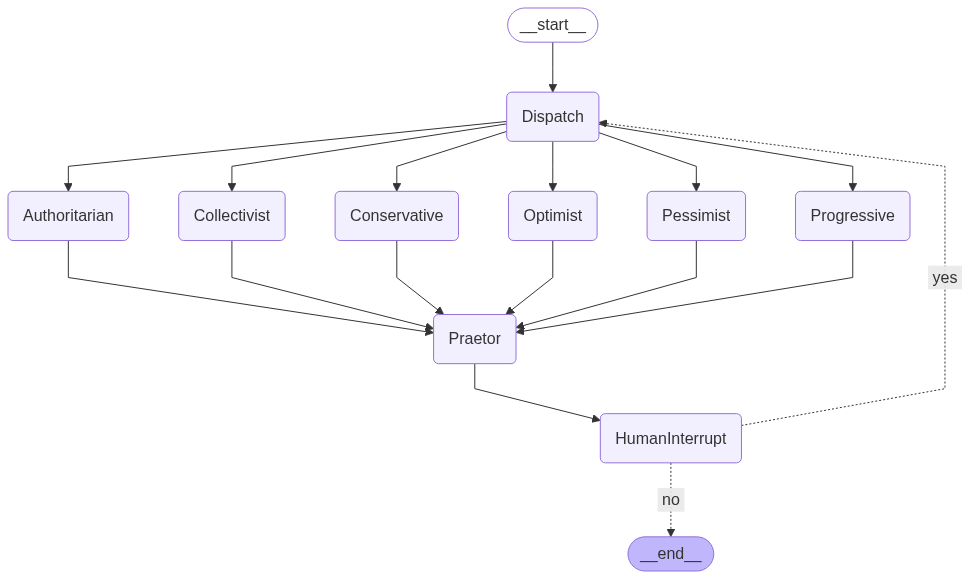

In [8]:
# Graph Visualization
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    print("Visualization failed.")
    pass

In [ ]:
# run the graph

initial_state = {
    "question": question,
    "loop_count": 1,
    "evaluations": [],          # list aggregator
    "praetor_outputs": {},      # dict merger
    "continue_": True,
    "role_prompts_rewrite": {}
}

state = initial_state
while state["continue_"]:
    print(f"\n===== Loop {state['loop_count']} =====")
    state = graph.invoke(state)
    # state["loop_count"] += 1      # this is moved to the human interrupt node


===== Loop 1 =====
[Authoritarian]: 
Mandatory biometric identification systems integrated with all public infrastructure.
AI-driven predictive policing and automated compliance enforcement platforms.
Centralized digital identity and credential management, universally regulated.




[Conservative]: 
* Enhanced cybersecurity measures, building upon existing frameworks to protect critical infrastructure.
* Refinements in industrial automation, specifically focusing on proven robotics and data analytics for manufacturing.
* Continued, practical application of cloud computing – prioritizing secure, reliable platforms over novel architectures.




[Collectivist]: 
•	Accessible AI-powered assistive tools, democratizing skillsets and opportunity for all citizens.
•	Localized & resilient microgrids with smart energy distribution, ensuring equitable access to power.
•	Collaborative digital fabrication networks (3D printing, CNC), fostering local production & reducing supply chain vulnerabiliti